# TMDB Box Office Prediction EDA + ML

![](https://cdn-images-1.medium.com/max/1200/1*vIR7iO-1GnY2xYxL6NiYkw.png)
[image-source](https://cdn-images-1.medium.com/max/1200/1*vIR7iO-1GnY2xYxL6NiYkw.png)

## Prerequisities

### Loading Libraries

In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

import warnings
warnings.filterwarnings("ignore")

['train.csv', 'sample_submission.csv', 'test.csv']


### Loading the data

In [74]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
sub_df = pd.read_csv('../input/sample_submission.csv')

### Inspecting the train set

In [75]:
train_df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


We have a variaty of data, numerical, categorical and even lists of json formats.

In [76]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

### Check for NA values in trainset

In [77]:
train_df.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

## Exploratory Data Analysis

In [78]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

So many columns and features to investigate, lets start by inspecting one by one each feature.

### Univariate Analysis

#### Revenue
Our target variable to be predicted

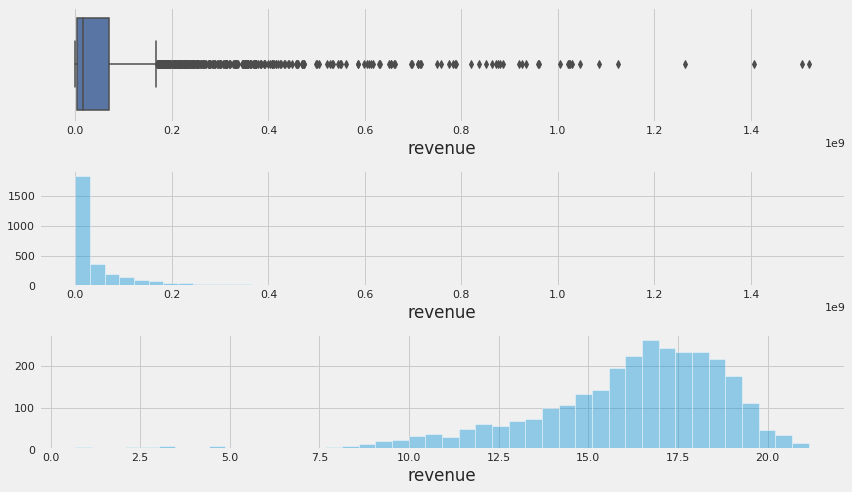

In [79]:
f, ax = plt.subplots(3, figsize=(12,7))
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train_df.revenue, ax = ax[0])
sns.distplot(a=train_df.revenue, kde = False, ax = ax[1])
sns.distplot(a=np.log1p(train_df.revenue), kde = False, ax = ax[2])
f.tight_layout()

train_df["log_revenue"] = np.log1p(train_df.revenue)

#### Budget

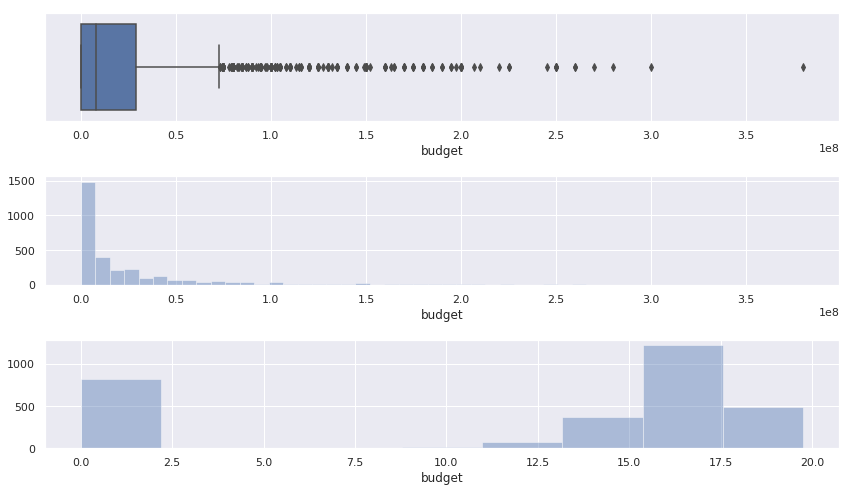

In [80]:
f, ax = plt.subplots(3, figsize=(12,7))
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train_df.budget, ax = ax[0])
sns.distplot(a=train_df.budget, kde = False, ax = ax[1])
sns.distplot(a=np.log1p(train_df.budget), kde = False, ax = ax[2])
f.tight_layout()

train_df["log_budget"] = np.log1p(train_df.budget)

#### Genres

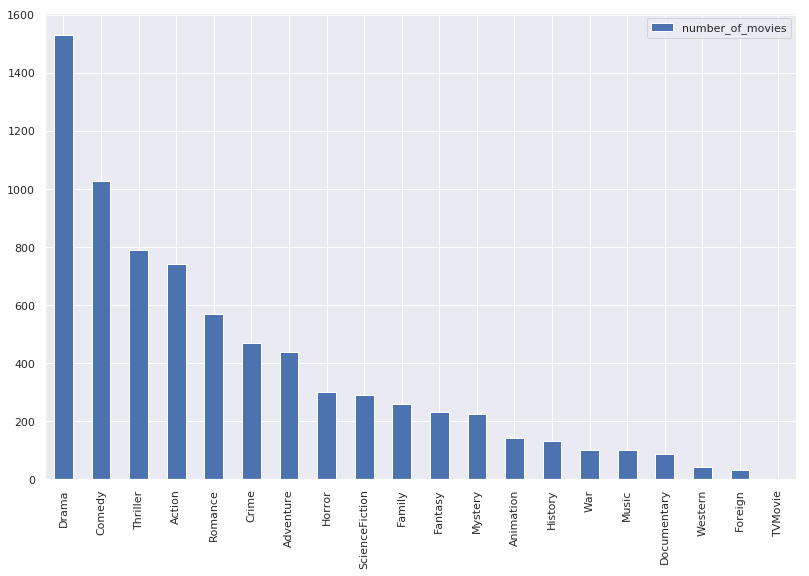

In [81]:
def genres_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace('\'','').replace(' ','').replace("name", "").replace("id", "").replace(":", "")
    ll = str1.split(",")[1::2]
    return ll

train_df["genres_processed"] = train_df.genres.apply(lambda elem: genres_preprocessing(elem))

genres_dict = dict()

for genre in train_df["genres_processed"]:
    for elem in genre:
        if elem not in genres_dict:
            genres_dict[elem] = 1
        else:
            genres_dict[elem] += 1


sns.set(rc={'figure.figsize':(12,8)})
genres_df = pd.DataFrame.from_dict(genres_dict, orient='index')
genres_df.columns = ["number_of_movies"]
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)
genres_df.plot.bar()

#### Number of Genres

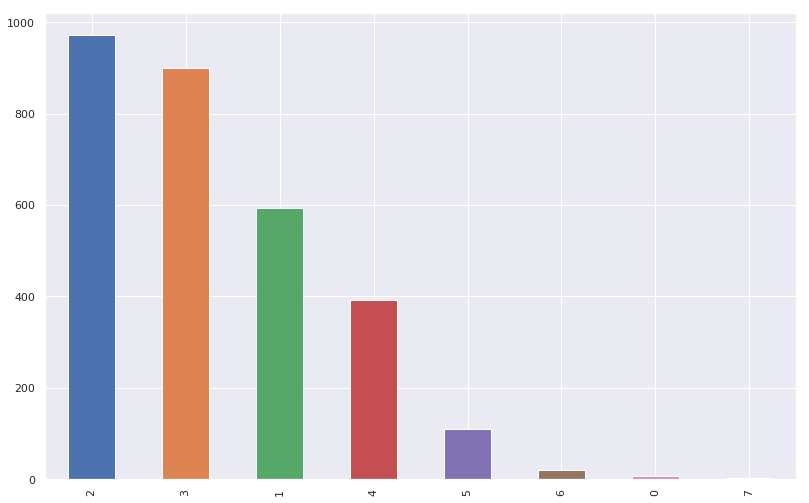

In [82]:
sns.set(rc={'figure.figsize':(12,8)})
train_df['num_genres'] = train_df['genres_processed'].apply(lambda x: len(x) if x != {} else 0)
train_df['num_genres'].value_counts().plot.bar()

### isGenre, creating new feature
isDrama, isComedy etc.

In [83]:
genres_df.index.values
for g in genres_df.index.values:
    train_df['genre_' + g] = train_df['genres_processed'].apply(lambda x: 1 if g in x else 0)

In [84]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'log_revenue', 'log_budget', 'genres_processed', 'num_genres',
       'genre_Drama', 'genre_Comedy', 'genre_Thriller', 'genre_Action',
       'genre_Romance', 'genre_Crime', 'genre_Adventure', 'genre_Horror',
       'genre_ScienceFiction', 'genre_Family', 'genre_Fantasy',
       'genre_Mystery', 'genre_Animation', 'genre_History', 'genre_War',
       'genre_Music', 'genre_Documentary', 'genre_Western', 'genre_Foreign',
       'genre_TVMovie'],
      dtype='object')

#### Original Language

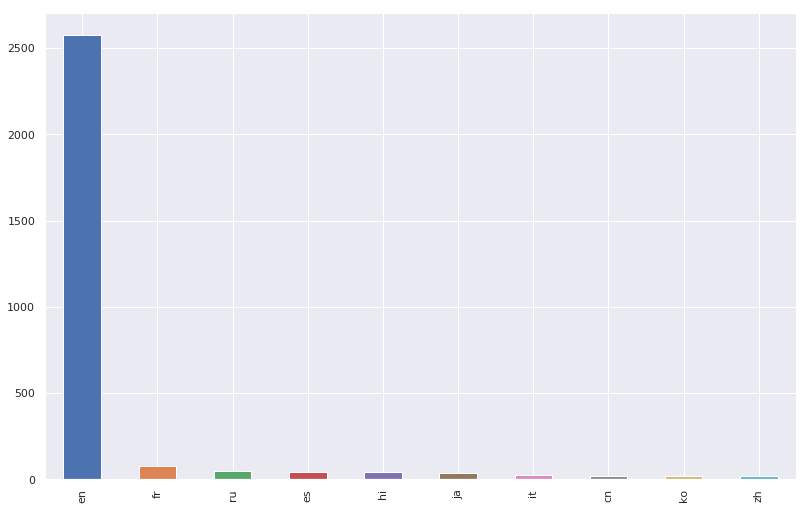

In [85]:
train_df.original_language.value_counts()[:10].plot.bar()

#### Production Companies

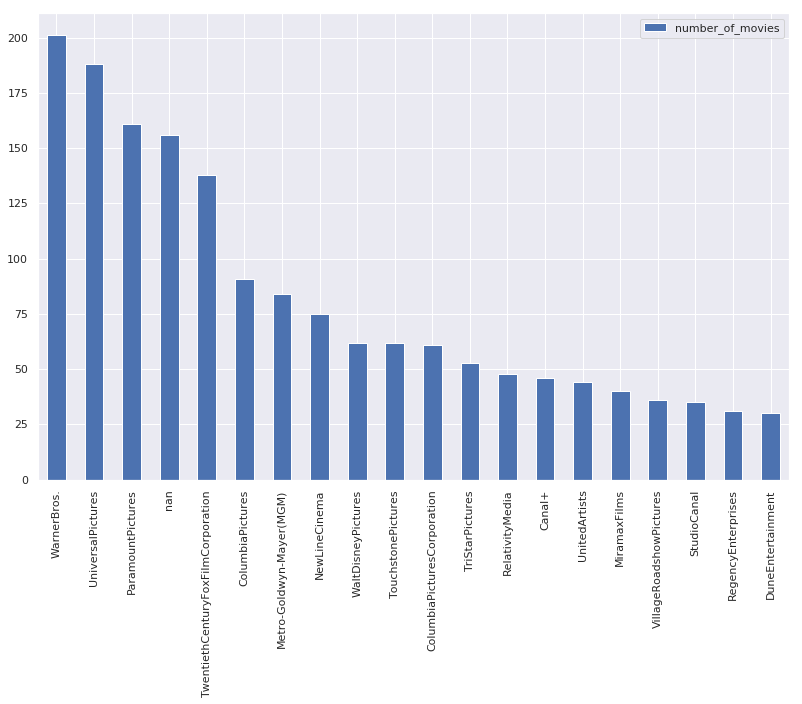

In [86]:
def production_companies_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("id", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["production_companies_processed"] = train_df.production_companies.apply(lambda elem: production_companies_preprocessing(elem))

production_companies_dict = dict()

for production_company in train_df["production_companies_processed"]:
    for elem in production_company:
        if elem not in production_companies_dict:
            production_companies_dict[elem] = 1
        else:
            production_companies_dict[elem] += 1


sns.set(rc={'figure.figsize':(12,8)})
production_companies_df = pd.DataFrame.from_dict(production_companies_dict, orient='index')
production_companies_df.columns = ["number_of_movies"]
production_companies_df = production_companies_df.sort_values(by="number_of_movies", ascending=False)
production_companies_df.head(20).plot.bar()

#### production_countries

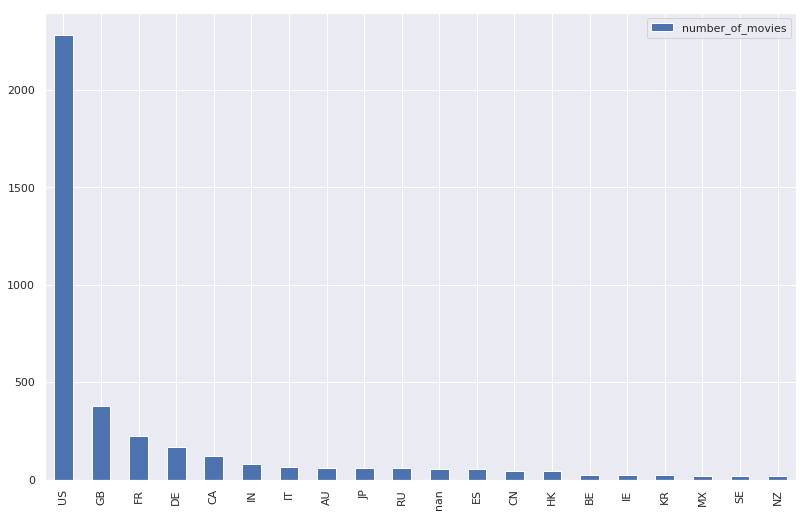

In [87]:
def production_countries_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("iso_3166_1", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["production_countries_processed"] = train_df.production_countries.apply(lambda elem: production_countries_preprocessing(elem))


production_countries_dict = dict()

for production_country in train_df["production_countries_processed"]:
    for elem in production_country:
        if elem not in production_countries_dict:
            production_countries_dict[elem] = 1
        else:
            production_countries_dict[elem] += 1



production_countries_df = pd.DataFrame.from_dict(production_countries_dict, orient='index')
production_countries_df.columns = ["number_of_movies"]
production_countries_df = production_countries_df.sort_values(by="number_of_movies", ascending=False)
production_countries_df.head(20).plot.bar()

### popularity

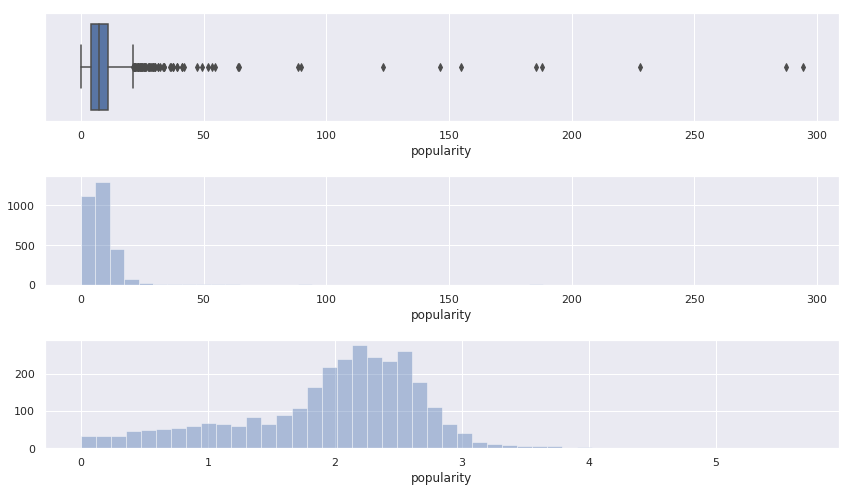

In [88]:
f, ax = plt.subplots(3, figsize=(12,7))
sns.boxplot(x=train_df.popularity, ax = ax[0])
sns.distplot(a=train_df.popularity, kde = False, ax = ax[1])
sns.distplot(a=np.log1p(train_df.popularity), kde = False, ax = ax[2])
f.tight_layout()

train_df["log_popularity"] = np.log1p(train_df.popularity)

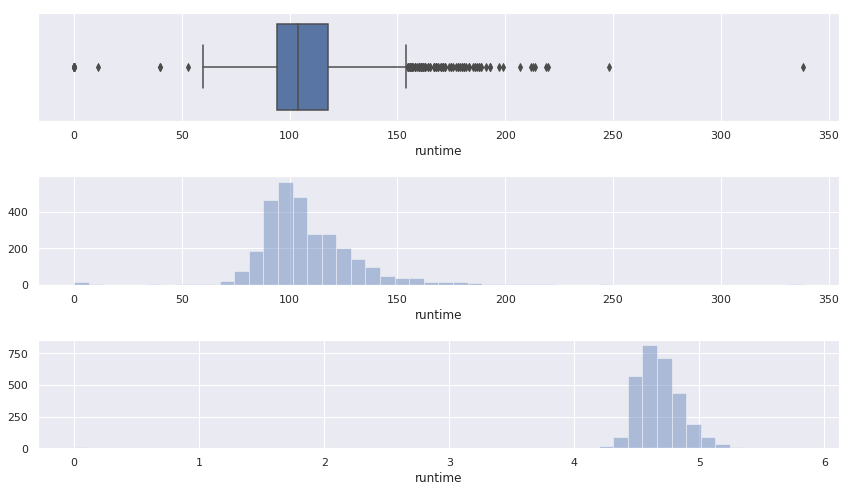

In [89]:
f, ax = plt.subplots(3, figsize=(12,7))
sns.boxplot(x=train_df.runtime, ax = ax[0])
sns.distplot(a=train_df.runtime.fillna(value=0), kde = False, ax = ax[1])
sns.distplot(a=np.log1p(train_df.runtime.fillna(value=1)), kde = False, ax = ax[2])
f.tight_layout()

train_df["runtime"] = np.log1p(train_df.runtime)

### EDA - Bivariate Analysis

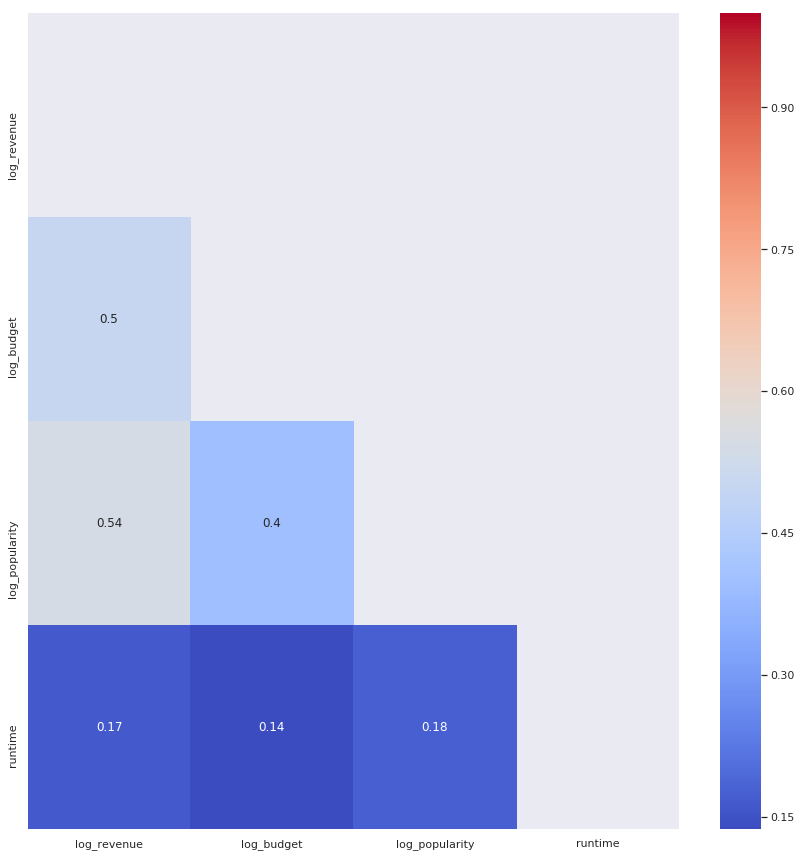

In [90]:
sns.set(rc={'figure.figsize':(13,14)})

# Compute the correlation matrix
corr = train_df[["log_revenue", "log_budget", "log_popularity", "runtime"]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

### Feature Engineering

### belongs_to_collection and revenue

0    2396
1     604
Name: has_collection, dtype: int64


Text(0.5, 1.0, 'Revenue for film with and without being in a collection')

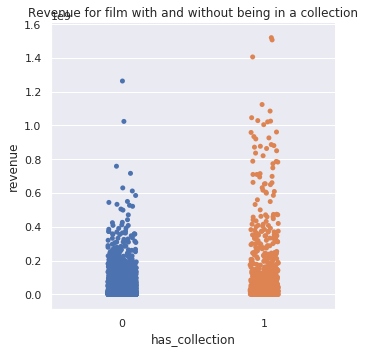

In [91]:
train_df['has_collection'] = [0 if pd.isnull(x) else 1 for x in train_df['belongs_to_collection']]
test_df['has_collection'] = [0 if pd.isnull(x) else 1 for x in test_df['belongs_to_collection']]
print(train_df['has_collection'].value_counts())

sns.catplot(x='has_collection', y='revenue', data=train_df)
plt.title('Revenue for film with and without being in a collection')

### homepage and revenue

0    2054
1     946
Name: has_homepage, dtype: int64


Text(0.5, 1.0, 'Revenue for film with and without homepage')

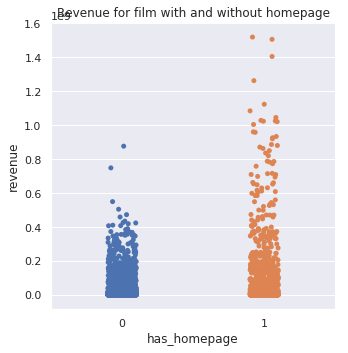

In [92]:
train_df['has_homepage'] = [0 if pd.isnull(x) else 1 for x in train_df['homepage']]
test_df['has_homepage'] = [0 if pd.isnull(x) else 1 for x in test_df['homepage']]
print(train_df['has_homepage'].value_counts())

sns.catplot(x='has_homepage', y='revenue', data=train_df)
plt.title('Revenue for film with and without homepage')

### Number of Genres per movie and revenues

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: num_of_genres, dtype: int64


Text(0.5, 1.0, 'Revenues for films with multiple genres')

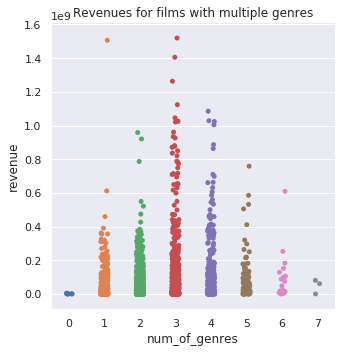

In [93]:
train_df["num_of_genres"] = train_df.genres_processed.apply(len)
print(train_df["num_of_genres"].value_counts())

sns.set(rc={'figure.figsize':(12, 38)})
sns.catplot(x='num_of_genres', y='revenue', data=train_df)
plt.title('Revenues for films with multiple genres')

Text(0.5, 1.0, 'Revenue for film and original_language')

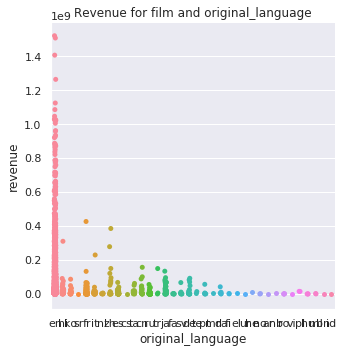

In [41]:
sns.catplot(x='original_language', y='revenue', data=train_df)
plt.title('Revenue for film and original_language')

## Machine Learning

#### Preparations before ML modeling

In [94]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'log_revenue', 'log_budget', 'genres_processed', 'num_genres',
       'genre_Drama', 'genre_Comedy', 'genre_Thriller', 'genre_Action',
       'genre_Romance', 'genre_Crime', 'genre_Adventure', 'genre_Horror',
       'genre_ScienceFiction', 'genre_Family', 'genre_Fantasy',
       'genre_Mystery', 'genre_Animation', 'genre_History', 'genre_War',
       'genre_Music', 'genre_Documentary', 'genre_Western', 'genre_Foreign',
       'genre_TVMovie', 'production_companies_processed',
       'production_countries_processed', 'log_popularity', 'has_collection',
       'has_homepage', 'num_of_genres'],
      dtype='object')

In [96]:
y = train_df['revenue']

columns_for_training = ["budget", "popularity", "runtime", "has_collection", "has_homepage"]

X = train_df[columns_for_training]

#### A function to calculate Root Mean Squared Logarithmic Error (RMSLE)

In [ ]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

### Baseline XGBoost

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from collections import Counter
from sklearn.metrics import mean_absolute_error
import scikitplot as skplt
import time
import random

import xgboost as xgb

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

import xgboost as xgb

start_time = time.time()

#predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_test = np.zeros(len(test_df))
num_fold = 0
num_of_splits = 10
mae = 0
#feature_importance_df = pd.DataFrame()

folds = KFold(n_splits=num_of_splits, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Fold:", num_fold)
    num_fold = num_fold + 1
    print()

    clf_stra_xgb = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

    clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                early_stopping_rounds=1000, eval_metric='rmse', verbose=100)

    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    #fold_importance_df["fold"] = n_fold + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions_valid = clf_stra_xgb.predict(xvalid)
    mae_valid = mean_absolute_error(yvalid, predictions_valid)
    mae += mae_valid
    #predictions_probas = clf_stra_xgb.predict_proba(xvalid)
    #predictions_probas_list += predictions_probas/num_of_folds

    predictions_test += clf_stra_xgb.predict(test_df[xtrain.columns])/10


#predictions = np.argmax(predictions_probas, axis=1)



print(predictions_test)
print("OOF Out-of-fold mae:", mae/num_of_splits)

### Bayesian Tuning

In [ ]:
def bayesian_tuning(xtrain, ytrain):
    
    from skopt import BayesSearchCV
    import xgboost as xgb
    
    
    # Classifier
    bayes_cv_tuner = BayesSearchCV(
        estimator = xgb.XGBRegressor(
            nthread = -1,
            objective = 'reg:linear',
            verbosity=1
        ),
        search_spaces = {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'min_child_weight': (0, 10),
            'n_estimators': (50, 100),
            'max_depth': (0, 12),
            'gamma': (1e-2, 10, 'log-uniform'),
            'subsample': (0.01, 1.0, 'uniform'),
            'colsample_bytree': (0.01, 1.0, 'uniform'),
            'colsample_bylevel': (0.01, 1.0, 'uniform'),
            'scale_pos_weight': (0.01, 1.0, 'uniform'),
            'reg_lambda': (1e-1, 10, 'log-uniform'),
            'reg_alpha': (1e-2, 1.0, 'log-uniform'),
            'max_delta_step': (0, 10, 'uniform'),
            'scale_pos_weight': (1e-2, 1, 'uniform')
        },
        cv = KFold(
            n_splits=10,
            shuffle=True,
            random_state=42
        ),
        n_jobs = 1,
        n_iter = 7,   
        verbose = 0,
        refit = True,
        random_state = 42
    )

    def status_print(optim_result):
        """Status callback durring bayesian hyperparameter search"""

        # Get all the models tested so far in DataFrame format
        all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

        # Get current parameters and the best parameters    
        best_params = pd.Series(bayes_cv_tuner.best_params_)
        print('Model #{}\nBest score: {}\nBest params: {}\n'.format(
            len(all_models),
            np.round(bayes_cv_tuner.best_score_, 4),
            bayes_cv_tuner.best_params_
        ))

        ### Save all model results
        #clf_name = bayes_cv_tuner.estimator.__class__.__name__
        #all_models.to_csv(clf_name+"_cv_results.csv")
        ###
        
    result = bayes_cv_tuner.fit(xtrain, ytrain, callback = status_print)
    return result
    
# Fit the model
#xtrain, ytrain = prepare_for_tuning(X, y, type_of_training=type_of_training)
result = bayesian_tuning(xtrain, ytrain)

In [ ]:
result.best_params_

### Training after tuning

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import time
import random
from sklearn.metrics import mean_absolute_error

import xgboost as xgb


print("baseline")

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

import xgboost as xgb

start_time = time.time()

#predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_test_tuned = np.zeros(len(test_df))
num_fold = 0
mae = 0
#feature_importance_df = pd.DataFrame()

folds = KFold(n_splits=10, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Fold:", num_fold)
    num_fold = num_fold + 1
    print()
    
    
    clf_stra_tuned_xgb = xgb.XGBRegressor(colsample_bytree = result.best_params_["colsample_bytree"],
                                    gamma=result.best_params_["gamma"],                 
                                    learning_rate=result.best_params_["learning_rate"],
                                    max_depth=result.best_params_["max_depth"],
                                    min_child_weight=result.best_params_["min_child_weight"],
                                    n_estimators=10000,
                                    reg_alpha=result.best_params_["reg_alpha"],
                                    reg_lambda=result.best_params_["reg_lambda"],
                                    subsample=result.best_params_["subsample"],
                                    seed=42)

    clf_stra_tuned_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                early_stopping_rounds=1000, eval_metric='rmse', verbose=100)

    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    #fold_importance_df["fold"] = n_fold + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions = clf_stra_tuned_xgb.predict(xvalid)
    #predictions_probas = clf_stra_xgb.predict_proba(xvalid)
    #predictions_probas_list += predictions_probas/num_of_folds

    predictions_test_tuned += clf_stra_tuned_xgb.predict(test_df[xtrain.columns])/10


#predictions = np.argmax(predictions_probas, axis=1)



print(predictions_test)

### Scaling the features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

temp_train_df = train_df[['budget', 'popularity', 'runtime']]
temp_test_df = test_df[['budget', 'popularity', 'runtime']]

scaler = MinMaxScaler()
temp_train_df = scaler.fit_transform(temp_train_df)
temp_test_df = scaler.transform(temp_test_df)

temp_train_df = pd.DataFrame(temp_train_df, columns=['budget', 'popularity', 'runtime'])
temp_test_df = pd.DataFrame(temp_test_df, columns=['budget', 'popularity', 'runtime'])

temp_train_df["belongs_to_collection_flag"] = train_df.belongs_to_collection_flag
temp_train_df["homepage_flag"] = train_df.homepage_flag

temp_test_df["belongs_to_collection_flag"] = test_df.belongs_to_collection_flag
temp_test_df["homepage_flag"] = test_df.homepage_flag

X = temp_train_df
y = train_df.revenue

print("scaling is done!")

### Training after Scaling

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

start_time = time.time()

#predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_scaled_test = np.zeros(len(test_df))
num_fold = 0
num_of_splits = 10
mae = 0
#feature_importance_df = pd.DataFrame()

folds = KFold(n_splits=num_of_splits, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Fold:", num_fold)
    num_fold = num_fold + 1
    print()

    clf_stra_scaled_xgb = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

    clf_stra_scaled_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                early_stopping_rounds=1000, eval_metric='rmse', verbose=100)

    predictions_valid = clf_stra_scaled_xgb.predict(xvalid)
    mae_valid = mean_absolute_error(yvalid, predictions_valid)
    mae += mae_valid

    predictions_scaled_test += clf_stra_scaled_xgb.predict(temp_test_df[xtrain.columns])/10


print(predictions_scaled_test)
print("OOF Out-of-fold mae:", mae/num_of_splits)

### Bayesian Tuning after scaling

In [ ]:
result = bayesian_tuning(xtrain, ytrain)

### Retraining after scaling and tuning 

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from collections import Counter
from sklearn.metrics import mean_absolute_error
import scikitplot as skplt
import time
import random

import xgboost as xgb

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

import xgboost as xgb

start_time = time.time()

#predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_scaled_tuned_test = np.zeros(len(test_df))
num_fold = 0
num_of_splits = 10
mae = 0
#feature_importance_df = pd.DataFrame()

folds = KFold(n_splits=num_of_splits, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Fold:", num_fold)
    num_fold = num_fold + 1
    print()

    clf_stra_scaled_tuned_xgb = xgb.XGBRegressor(colsample_bytree = result.best_params_["colsample_bytree"],
                                    gamma=result.best_params_["gamma"],                 
                                    learning_rate=result.best_params_["learning_rate"],
                                    max_depth=result.best_params_["max_depth"],
                                    min_child_weight=result.best_params_["min_child_weight"],
                                    n_estimators=10000,
                                    reg_alpha=result.best_params_["reg_alpha"],
                                    reg_lambda=result.best_params_["reg_lambda"],
                                    subsample=result.best_params_["subsample"],
                                    seed=42)

    clf_stra_scaled_tuned_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                early_stopping_rounds=1000, eval_metric='rmse', verbose=100)

    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["feature"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].index
    #fold_importance_df["fscore"] = pd.DataFrame.from_dict(data=clf_stra_xgb.get_fscore(), orient="index", columns=["FScore"])["FScore"].values
    #fold_importance_df["fold"] = n_fold + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions_valid = clf_stra_scaled_tuned_xgb.predict(xvalid)
    mae_valid = mean_absolute_error(yvalid, predictions_valid)
    mae += mae_valid
    #predictions_probas = clf_stra_xgb.predict_proba(xvalid)
    #predictions_probas_list += predictions_probas/num_of_folds

    predictions_scaled_tuned_test += clf_stra_scaled_tuned_xgb.predict(temp_test_df[xtrain.columns])/10


#predictions = np.argmax(predictions_probas, axis=1)


print(predictions_scaled_tuned_test)
print("OOF mae: ",mae/num_of_splits)

In [ ]:
gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['revenue'] = predictions_test
submission.to_csv('clf_xgb_baseline.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['revenue'] = predictions_test_tuned
submission.to_csv('clf_xgb_tuned.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['revenue'] = predictions_scaled_test
submission.to_csv('clf_xgb_baseline_scaled.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['revenue'] = predictions_scaled_tuned_test
submission.to_csv('clf_xgb_scaled_tuned.csv', index=False)